In [ ]:
# Installing 
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.4 MB/s eta 0:00:00

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import classification_report, f1_score
from random import sample
import seaborn as sns
import sklearn as sk
import io
import os
import nltk
from nltk.data import find
import matplotlib.pyplot as plt
import re
import gensim

In [ ]:
# Mount drive for saving model checkpoints

from google.colab import drive
drive.mount('/content/drive')

checkpoint_dir = 'drive/MyDrive/Models/'

KeyboardInterrupt: ignored

In [ ]:
def make_plot(axs,
              model_history,  
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower = np.min(model_history.history[metric]) * 0.9

        y_lim_upper = np.max(model_history.history[metric]) * 1.1

        ax1 = axs[i]
        ax1.plot(model_history.history[metric])
        ax1.plot(model_history.history['val_%s' % metric])
        ax1.set_ylabel(metric, bbox=box)
        ax1.set_ylim(y_lim_lower, y_lim_upper)
     

In [ ]:
# Create mapping from numeric labels to text labels (different for six way vs. binary)
label_map = {'six classes': ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'], 'binary': ['true', 'false'], 'ternary':['true','neither','false']}

In [ ]:
def evaluate_model_claim_input(model, model_history, train_input, train_labels, test_input, test_labels):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input['input_ids'], test_input['token_type_ids'], test_input['attention_mask']])
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()


  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  elif len(np.unique(train_labels)) == 3:
    target_names = label_map['ternary']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example statements:")
      example_pool = df[df['label'] == class_label]['claim']
      print(sample(list(example_pool), 3))


In [ ]:
def evaluate_model_claim_features(model, model_history, train_input, train_labels, test_input, test_labels, emoLex_input, LIWC_input):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input['input_ids'], test_input['token_type_ids'], test_input['attention_mask'], emoLex_input, LIWC_input])
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()


  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  elif len(np.unique(train_labels)) == 3:
    target_names = label_map['ternary']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example statements:")
      example_pool = df[df['label'] == class_label]['claim']
      print(sample(list(example_pool), 3))


In [ ]:
def evaluate_model_claim_features2(model, model_history, train_input, train_labels, test_input, test_labels, additional_input):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input['input_ids'], test_input['token_type_ids'], test_input['attention_mask'], additional_input])
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()


  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  elif len(np.unique(train_labels)) == 3:
    target_names = label_map['ternary']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example statements:")
      example_pool = df[df['label'] == class_label]['claim']
      print(sample(list(example_pool), 3))


In [ ]:
def evaluate_model_concat_input(model, model_history, train_input, train_labels, test_input, test_labels):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input['input_ids'], test_input['token_type_ids'], test_input['attention_mask']])
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()


  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  elif len(np.unique(train_labels)) == 3:
    target_names = label_map['ternary']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example statements:")
      example_pool = df[df['label'] == class_label]['combined_text']
      print(sample(list(example_pool), 3))


In [ ]:
def evaluate_model_concat_features(model, model_history, train_input, train_labels, test_input, test_labels, emoLex_input, LIWC_input):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input['input_ids'], test_input['token_type_ids'], test_input['attention_mask'], emoLex_input, LIWC_input])
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()


  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  elif len(np.unique(train_labels)) == 3:
    target_names = label_map['ternary']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example statements:")
      example_pool = df[df['label'] == class_label]['combined_text']
      print(sample(list(example_pool), 3))


In [ ]:
def evaluate_model_concat_features2(model, model_history, train_input, train_labels, test_input, test_labels, additional_input):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input['input_ids'], test_input['token_type_ids'], test_input['attention_mask'], additional_input])
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()


  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  elif len(np.unique(train_labels)) == 3:
    target_names = label_map['ternary']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example statements:")
      example_pool = df[df['label'] == class_label]['combined_text']
      print(sample(list(example_pool), 3))


In [ ]:
def evaluate_model_concatPOS_input(model, model_history, train_input, train_labels, test_input, test_labels):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input['input_ids'], test_input['token_type_ids'], test_input['attention_mask']])
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()


  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  elif len(np.unique(train_labels)) == 3:
    target_names = label_map['ternary']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example statements:")
      example_pool = df[df['label'] == class_label]['combined_pos']
      print(sample(list(example_pool), 3))


In [ ]:
# Load the LIAR-PLUS dataset
from google.colab import files
uploaded = files.upload()


Saving final_liar_features.csv to final_liar_features.csv


In [ ]:
liar_plus_dataset = pd.read_csv(io.BytesIO(uploaded['final_liar_features.csv']))
# Dataset is now stored in a Pandas Datafram

In [ ]:
# Split the dataset into train, validation, and test sets
liar_plus_dataset['label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [ ]:
print("6 class: ",liar_plus_dataset['label_num'].unique())
print("3 class: ",liar_plus_dataset['ternary_label_num'].unique())
print("2 class: ",liar_plus_dataset['binary_label_num'].unique())

6 class:  [1 3 4 5 2 0]
3 class:  [2 1 0]
2 class:  [1 0]


In [ ]:
# Load the LIAR Plus dataset from a CSV file
df = liar_plus_dataset

In [ ]:
df.shape

(12836, 137)

Data Preparation

In [ ]:
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
train_examples = train.loc[:,'combined_text']
validate_examples = validate.loc[:,'combined_text']
test_examples = test.loc[:,'combined_text']

In [ ]:
train_labels = train.loc[:,'label_num']
validate_labels = validate.loc[:,'label_num']
test_labels = test.loc[:,'label_num']

In [ ]:
train_examples_claim = train.loc[:,'claim']
validate_examples_claim = validate.loc[:,'claim']
test_examples_claim = test.loc[:,'claim']

In [ ]:
train_binary_labels = train.loc[:,'binary_label_num']
validate_binary_labels = validate.loc[:,'binary_label_num']
test_binary_labels = test.loc[:,'binary_label_num']

In [ ]:
train_ternary_labels = train.loc[:,'ternary_label_num']
validate_ternary_labels = validate.loc[:,'ternary_label_num']
test_ternary_labels = test.loc[:,'ternary_label_num']

In [ ]:
for i in range(len(list(df.columns))):
  print(i,list(df.columns)[i])

0 id
1 label
2 label_num
3 binary_label_num
4 ternary_label_num
5 claim
6 combined_text
7 fear
8 anger
9 anticipation
10 trust
11 surprise
12 positive
13 negative
14 sadness
15 disgust
16 joy
17 Segment
18 WC
19 Analytic
20 Clout
21 Authentic
22 Tone
23 WPS
24 BigWords
25 Dic
26 Linguistic
27 function
28 pronoun
29 ppron
30 i
31 we
32 you
33 shehe
34 they
35 ipron
36 det
37 article
38 number
39 prep
40 auxverb
41 adverb
42 conj
43 negate
44 verb
45 adj
46 quantity
47 Drives
48 affiliation
49 achieve
50 power
51 Cognition
52 allnone
53 cogproc
54 insight
55 cause
56 discrep
57 tentat
58 certitude
59 differ
60 memory
61 Affect
62 tone_pos
63 tone_neg
64 emotion
65 emo_pos
66 emo_neg
67 emo_anx
68 emo_anger
69 emo_sad
70 swear
71 Social
72 socbehav
73 prosocial
74 polite
75 conflict
76 moral
77 comm
78 socrefs
79 family
80 friend
81 female
82 male
83 Culture
84 politic
85 ethnicity
86 tech
87 Lifestyle
88 leisure
89 home
90 work
91 money
92 relig
93 Physical
94 health
95 illness
96 wellne

In [ ]:
emoLex_train = np.asarray(df.iloc[train_examples.index,7:17])
emoLex_validate = np.asarray(df.iloc[validate_examples.index,7:17])
emoLex_test = np.asarray(df.iloc[test_examples.index,7:17])

In [ ]:
extreme_emotion_col_idx = [7,8,9,10,11,14,15,16,50,67,68,69]
extreme_emotion_train = np.asarray(df.iloc[train_examples.index,extreme_emotion_col_idx])
extreme_emotion_validate = np.asarray(df.iloc[validate_examples.index,extreme_emotion_col_idx])
extreme_emotion_test = np.asarray(df.iloc[test_examples.index,extreme_emotion_col_idx])

In [ ]:
positive_col_idx = [10,12,16,65]
positive_train = np.asarray(df.iloc[train_examples.index,positive_col_idx])
positive_validate = np.asarray(df.iloc[validate_examples.index,positive_col_idx])
positive_test = np.asarray(df.iloc[test_examples.index,positive_col_idx])

In [ ]:
negative_col_idx = [7,8,9,13,14,15,66,67,68,69]
negative_train = np.asarray(df.iloc[train_examples.index,negative_col_idx])
negative_validate = np.asarray(df.iloc[validate_examples.index,negative_col_idx])
negative_test = np.asarray(df.iloc[test_examples.index,negative_col_idx])

In [ ]:
LIWC_train = np.asarray(df.iloc[train_examples.index,17:-1])
LIWC_validate = np.asarray(df.iloc[validate_examples.index,17:-1])
LIWC_test = np.asarray(df.iloc[test_examples.index,17:-1])

In [ ]:
emoLex_LIWC_train = np.asarray(df.iloc[train_examples.index,7:-1])
emoLex_LIWC_validate = np.asarray(df.iloc[validate_examples.index,7:-1])
emoLex_LIWC_test = np.asarray(df.iloc[test_examples.index,7:-1])

In [ ]:
POS_concat_train = np.asarray(df.iloc[train_examples.index,-1])
POS_concat_validate = np.asarray(df.iloc[validate_examples.index,-1])
POS_concat_test = np.asarray(df.iloc[test_examples.index,-1])

In [ ]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length = 100

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(list(train_examples), padding='max_length',  return_tensors='tf')
valid_encodings = bert_tokenizer(list(validate_examples), padding='max_length',  return_tensors='tf')
test_encodings = bert_tokenizer(list(test_examples), padding='max_length',  return_tensors='tf')

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings_claim = bert_tokenizer(list(train_examples_claim), padding='max_length',  return_tensors='tf')
valid_encodings_claim = bert_tokenizer(list(validate_examples_claim), padding='max_length',  return_tensors='tf')
test_encodings_claim = bert_tokenizer(list(test_examples_claim), padding='max_length',  return_tensors='tf')

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings_POS = bert_tokenizer(list(POS_concat_train), padding='max_length',  return_tensors='tf')
valid_encodings_POS = bert_tokenizer(list(POS_concat_validate), padding='max_length',  return_tensors='tf')
test_encodings_POS = bert_tokenizer(list(POS_concat_test), padding='max_length',  return_tensors='tf')

In [ ]:
train_encodings.input_ids[:3]

<tf.Tensor: shape=(3, 512), dtype=int32, numpy=
array([[ 101,  107, 1109, ...,    0,    0,    0],
       [ 101, 1284, 1127, ...,    0,    0,    0],
       [ 101, 1130, 1349, ...,    0,    0,    0]], dtype=int32)>

In [ ]:
len(LIWC_train)

7701

# Experiments

#### BERT Baseline (only claim)

In [ ]:
def create_bert_pooler_model(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a baseline classification model with BERT using a single text input. Use the Pooler Output for classification purposes.
    """

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              
    
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')


    return classification_model

In [ ]:
def create_bert_CLS_model(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a baseline classification model with BERT using a single text input. Use the CLS token for classification purposes.
    """

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              
    
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]


    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')


    return classification_model

In [ ]:
bert_baseline_pooler_model_6class = create_bert_pooler_model(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_pooler_model_6class_history = bert_baseline_pooler_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1070s 1s/step - loss: 1.7810 - accuracy: 0.2031 - val_loss: 1.7320 - val_accuracy: 0.2295
Epoch 2/2
963/963 [==============================] - 1036s 1s/step - loss: 1.7288 - accuracy: 0.2293 - val_loss: 1.7154 - val_accuracy: 0.2556


Learning Curve


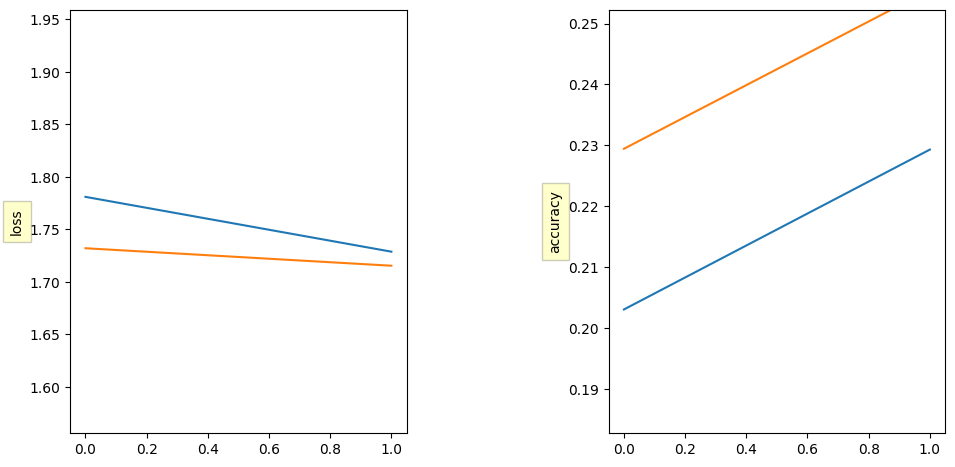

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.24      0.64      0.35       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.22      0.12      0.16       534
 mostly-true       0.27      0.50      0.35       469
        true       0.00      0.00      0.00       402

    accuracy                           0.25      2568
   macro avg       0.12      0.21      0.14      2568
weighted avg       0.14      0.25      0.17      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


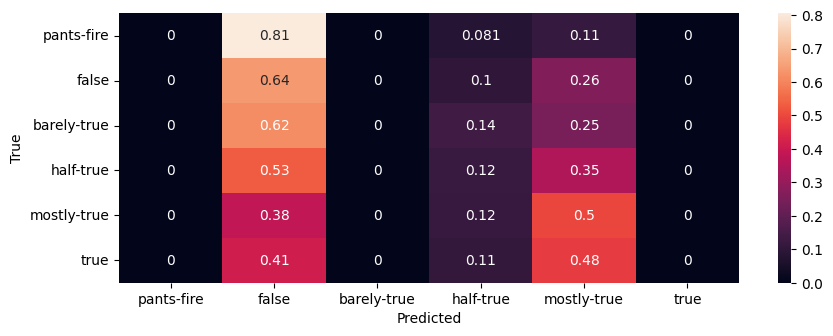

Class(es) with lowest f1 score: pants-fire
Example statements:
['"Photo of ""tea party"" protests shows crowd sprawling from Capitol to Washington Monument"', 'In 2006, Planned Parenthood performed more prevention services and cancer screenings than abortions, but in 2013, there were more abortions.', 'Rebuilding three high schools will benefit 40 percent of Portland Public School students.']
Class(es) with lowest f1 score: barely-true
Example statements:
['The insurance risk corridors arent going broke like Republicans predicted.', 'Says Gov. Scott Walker has dropped Wisconsin to 45th in the nation in job growth prospects while campaigning for president out of state.', 'Says the Koch brothers funded the fight to let flood insurance premiums soar ... Now theyre spending millions to buy a Senate seat for Bill Cassidy so he can fight for them.']
Class(es) with lowest f1 score: true
Example statements:
['Crime is down in Arizona.', 'Says he paid one dollar for a sweater at Kohls.', 'Said 

In [ ]:
evaluate_model_claim_input(bert_baseline_pooler_model_6class, bert_baseline_pooler_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels)

In [ ]:
bert_baseline_CLS_model_6class = create_bert_CLS_model(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_CLS_model_6class_history = bert_baseline_CLS_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1050s 1s/step - loss: 1.8043 - accuracy: 0.1919 - val_loss: 1.7573 - val_accuracy: 0.1944
Epoch 2/2
963/963 [==============================] - 1032s 1s/step - loss: 1.7704 - accuracy: 0.1883 - val_loss: 1.7537 - val_accuracy: 0.1995


Learning Curve


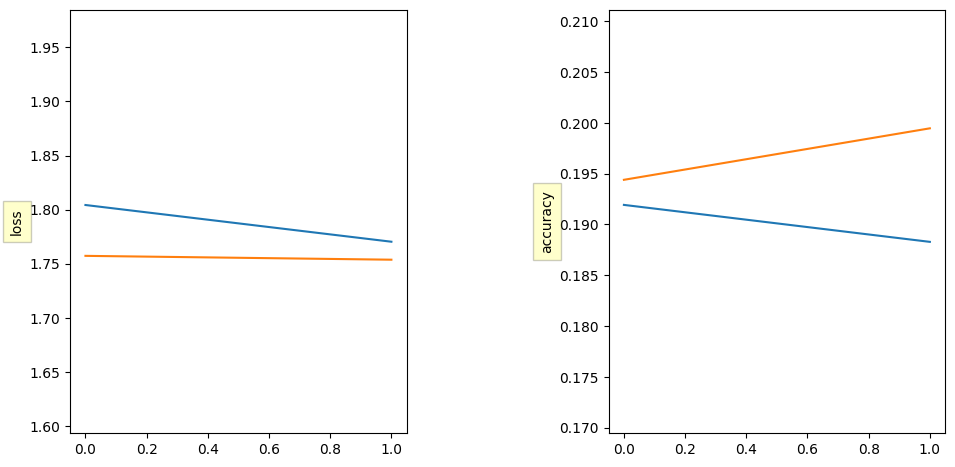

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.20      1.00      0.34       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.00      0.00      0.00       534
 mostly-true       0.00      0.00      0.00       469
        true       0.00      0.00      0.00       402

    accuracy                           0.20      2568
   macro avg       0.03      0.17      0.06      2568
weighted avg       0.04      0.20      0.07      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


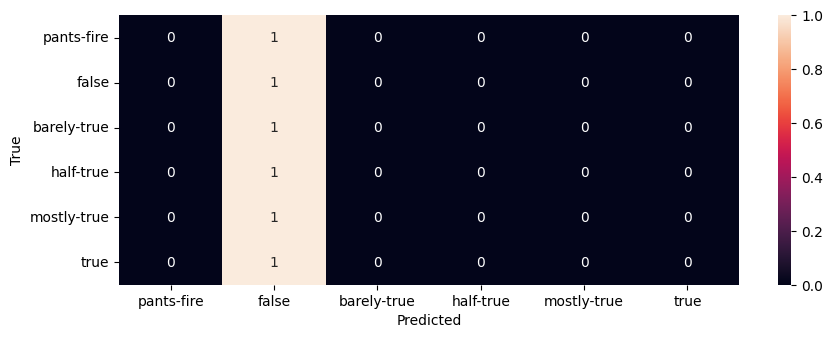

Class(es) with lowest f1 score: pants-fire
Example statements:
['The non-profit groupFeeding America is lying when it claimsthat one in five kids is fighting starvation daily in the United States.', 'Says Barack Obama knew half of the population of the United States would lose their health insurance.', 'Ted Cruz helps run two national organizations that have been leading the push to give amnesty to illegal immigrants.']
Class(es) with lowest f1 score: barely-true
Example statements:
['Says Hillary Clintons plan would tax many small businesses by almost 50 percent.', 'The Republicans still want to privatize (Social Security). In fact, their whole idea is to turn over the Social Security trust fund to Wall Street.', '"Mitch McConnell opposed ""legislation to create and protect Kentucky jobs . . . help for the unemployed. . . health care for Kentucky\'s children,"" and ""fair pay for women."""']
Class(es) with lowest f1 score: half-true
Example statements:
['The Medicare drug program resu

In [ ]:
evaluate_model_claim_input(bert_baseline_CLS_model_6class, bert_baseline_CLS_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels)

### BERT + concat
###### Pooler vs CLS

In [ ]:
bert_concat_pooler_model_6class = create_bert_pooler_model(checkpoint=model_checkpoint, num_classes=6)
bert_concat_pooler_model_6class_history = bert_concat_pooler_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
963/963 [==============================] - 1047s 1s/step - loss: 1.7741 - accuracy: 0.2136 - val_loss: 1.7094 - val_accuracy: 0.2345
Epoch 2/3
963/963 [==============================] - 1018s 1s/step - loss: 1.7095 - accuracy: 0.2405 - val_loss: 1.7066 - val_accuracy: 0.2466
Epoch 3/3
963/963 [==============================] - 1018s 1s/step - loss: 1.6423 - accuracy: 0.2806 - val_loss: 1.6896 - val_accuracy: 0.2657


Learning Curve


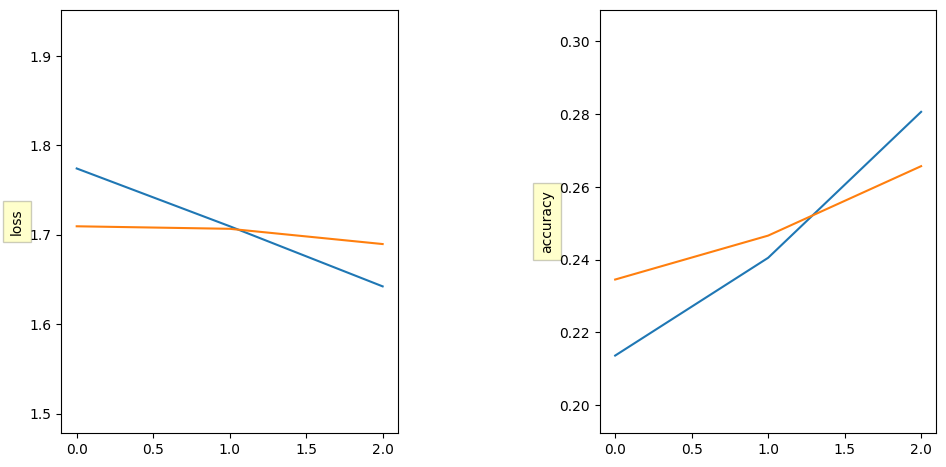

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.39      0.32      0.35       211
       false       0.28      0.32      0.30       523
 barely-true       0.21      0.26      0.23       429
   half-true       0.28      0.28      0.28       534
 mostly-true       0.24      0.18      0.20       469
        true       0.25      0.23      0.24       402

    accuracy                           0.26      2568
   macro avg       0.27      0.26      0.27      2568
weighted avg       0.26      0.26      0.26      2568

Confusion matrix


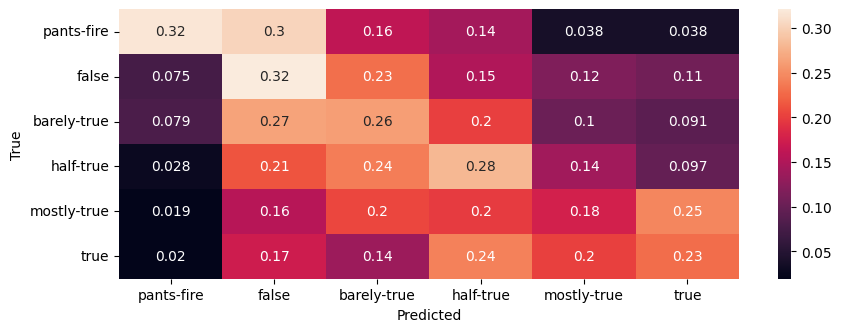

Class(es) with lowest f1 score: mostly-true
Example statements:
['The interest on the debt now is going to approach in the next couple of years ... what we spend in the national defense budget. federal-budget military abc-news-week rand-paul Candidate for U.S. Senate and physician Kentucky', 'From 1980 to 1990, the top 1 percent saw their income go up by roughly 80 percent while the median wage in the country over (the same) 10 years went up 3 percent. economy history income pundits taxes rachel-maddow MSNBC host ', '"Clinton has ""raised the most money from Washington lobbyists ... from the health industry, drug companies, health insurance companies (and) the defense industry.""" ethics john-edwards former senator North Carolina']


In [ ]:
evaluate_model_concat_input(bert_concat_pooler_model_6class, bert_concat_pooler_model_6class_history, train_encodings, train_labels, test_encodings, test_labels)

In [ ]:
bert_concat_pooler_model_6class.save(checkpoint_dir + 'bert_concat_pooler_model_6class')

In [ ]:
bert_concat_CLS_model_6class = create_bert_CLS_model(checkpoint=model_checkpoint, num_classes=6)
bert_concat_CLS_model_6class_history = bert_concat_CLS_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2,
    shuffle=True
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1035s 1s/step - loss: 1.7775 - accuracy: 0.1930 - val_loss: 1.7120 - val_accuracy: 0.2357
Epoch 2/2
963/963 [==============================] - 1020s 1s/step - loss: 1.7201 - accuracy: 0.2324 - val_loss: 1.6800 - val_accuracy: 0.2466


Learning Curve


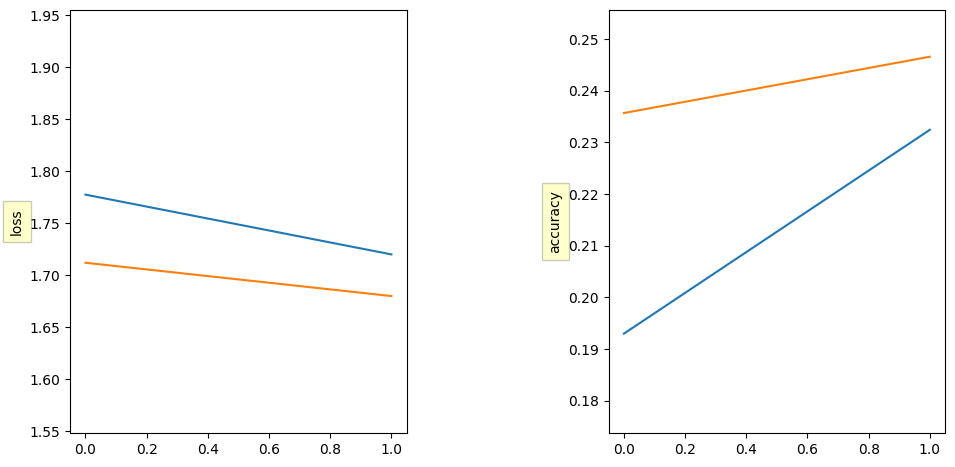

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.49      0.24      0.32       211
       false       0.28      0.41      0.33       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.23      0.63      0.34       534
 mostly-true       0.00      0.00      0.00       469
        true       0.28      0.16      0.20       402

    accuracy                           0.26      2568
   macro avg       0.21      0.24      0.20      2568
weighted avg       0.19      0.26      0.19      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


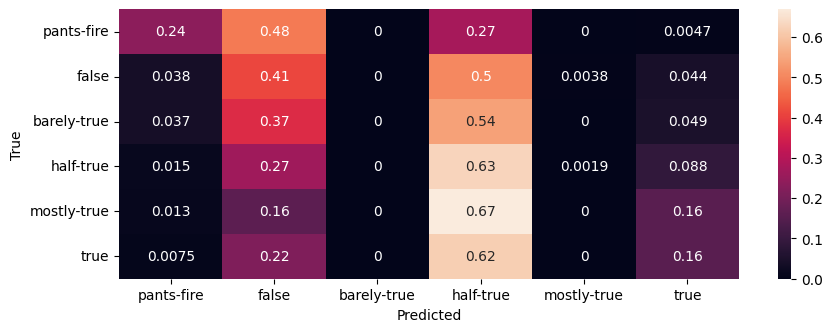

Class(es) with lowest f1 score: barely-true
Example statements:
['When it comes to taking cuts in tough budget times, Wisconsin state workers havent had to sacrifice. labor state-budget club-growth  ', "Says Dick Cheney de-Baathisized the Iraqi government and created ISIS. foreign-policy iraq terrorism chris-matthews Host of MSNBC's Hardball ", 'Many Nevadans relied on Uber for work, but after accepting $70,000 from taxi companies, Catherine Cortez Masto went after Uber ... (driving) them out of town. transportation freedom-partners-action-fund  ']
Class(es) with lowest f1 score: mostly-true
Example statements:
['The geography of poverty has changed fundamentally in the last 15 years, with more of it concentrated in fragile and conflict states. foreign-policy david-miliband  ', 'Twenty-three million Americans suffer from addiction, but only 1 in 10 get treatment. drugs health-care public-health hillary-clinton Presidential candidate New York', '"California gubernatorial candidate Steve

In [ ]:
evaluate_model_concat_input(bert_concat_CLS_model_6class, bert_concat_CLS_model_6class_history, train_encodings, train_labels, test_encodings, test_labels)

In [ ]:
bert_concat_pooler_model_6class.save(checkpoint_dir + 'bert_concat_CLS_model_6class')

In [ ]:
bert_concat_pooler_model_6class_POS = create_bert_pooler_model(checkpoint=model_checkpoint, num_classes=6)
bert_concat_pooler_model_6class_POS_history = bert_concat_pooler_model_6class_POS.fit(
    [train_encodings_POS.input_ids, train_encodings_POS.token_type_ids, train_encodings_POS.attention_mask], 
    train_labels,   
    validation_data=(
        [valid_encodings_POS.input_ids, valid_encodings_POS.token_type_ids, valid_encodings_POS.attention_mask],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1043s 1s/step - loss: 1.8124 - accuracy: 0.1987 - val_loss: 1.7539 - val_accuracy: 0.2026
Epoch 2/2
963/963 [==============================] - 1023s 1s/step - loss: 1.7682 - accuracy: 0.2002 - val_loss: 1.7558 - val_accuracy: 0.2026


Learning Curve


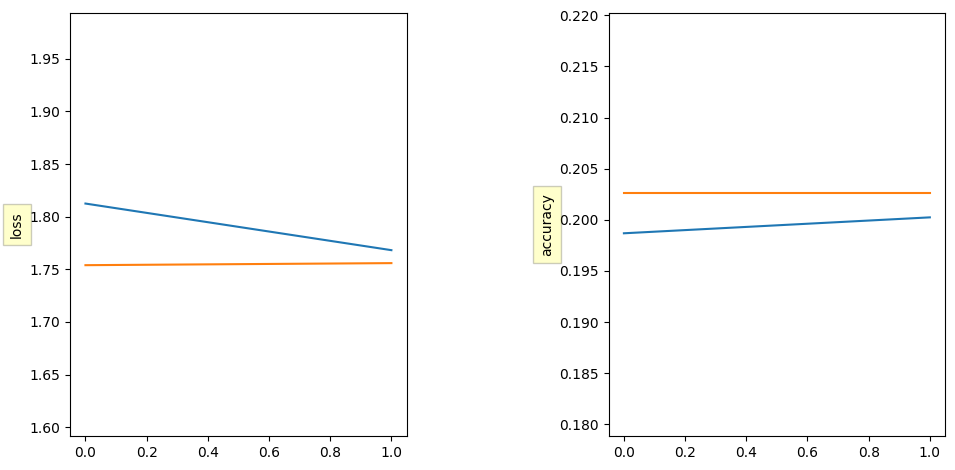

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.00      0.00      0.00       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.21      1.00      0.34       534
 mostly-true       0.00      0.00      0.00       469
        true       0.00      0.00      0.00       402

    accuracy                           0.21      2568
   macro avg       0.03      0.17      0.06      2568
weighted avg       0.04      0.21      0.07      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


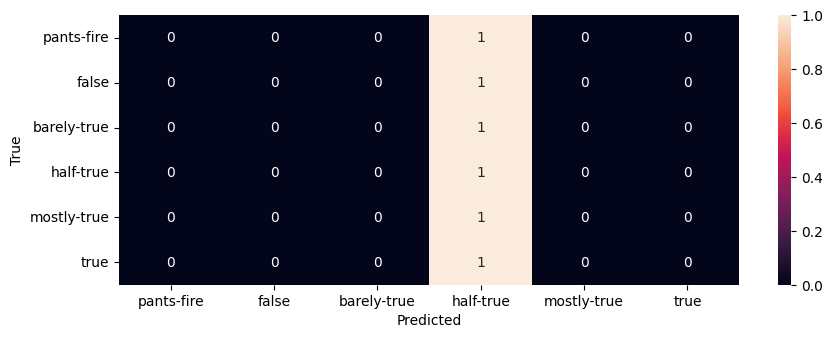

Class(es) with lowest f1 score: pants-fire
Example statements:
['An anonymous e-mail says that Hillary Clinton advocates communism. economy chain-email   #DT JJ NN VBZ IN NNP NNP VBZ NN . NN JJ', 'The ACLU has filed a suit to end prayer from the military completely. military religion chain-email   #DT NNP VBZ VBN DT NN TO VB NN IN DT JJ RB . JJ NN NN', 'Says former Federal Reserve Chairman Alan Greenspan said that if the workers are more insecure, thats very healthy for the society because theyll serve the masters gladly and passively. economy labor workers facebook-posts Social media posting  #VBZ JJ NNP NNP NNP NNP NNP VBD IN IN DT NNS VBP JJR NN , NNS RB JJ IN DT NN IN NN VBP DT NNS RB CC RB . NN NN NNS JJ NNP NNS VBG']
Class(es) with lowest f1 score: false
Example statements:
['Scott Walker had a 2.3 GPA when he was asked to leave Marquette University for cheating. candidates-biography education elections facebook-posts Social media posting  #NNP NNP VBD DT CD NN WRB PRP VBD VBN TO

In [ ]:
evaluate_model_concatPOS_input(bert_concat_pooler_model_6class_POS, bert_concat_pooler_model_6class_POS_history, train_encodings_POS, train_labels, test_encodings_POS, test_labels)

In [ ]:
bert_concat_pooler_model_6class_POS.save(checkpoint_dir + 'bert_concat_pooler_model_6class_POS')

In [ ]:
bert_concat_CLS_model_6class_POS = create_bert_CLS_model(checkpoint=model_checkpoint, num_classes=6)
bert_concat_CLS_model_6class_POS_history = bert_concat_CLS_model_6class_POS.fit(
    [train_encodings_POS.input_ids, train_encodings_POS.token_type_ids, train_encodings_POS.attention_mask], 
    train_labels,   
    validation_data=(
        [valid_encodings_POS.input_ids, valid_encodings_POS.token_type_ids, valid_encodings_POS.attention_mask],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1045s 1s/step - loss: 1.7845 - accuracy: 0.1939 - val_loss: 1.7140 - val_accuracy: 0.2505
Epoch 2/2
963/963 [==============================] - 1025s 1s/step - loss: 1.7318 - accuracy: 0.2274 - val_loss: 1.6945 - val_accuracy: 0.2610


Learning Curve


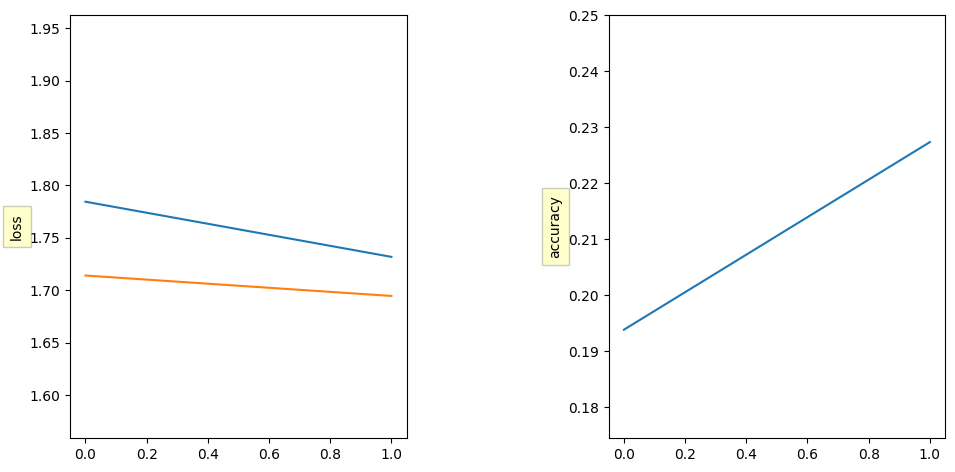

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.54      0.20      0.29       211
       false       0.25      0.43      0.32       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.24      0.11      0.15       534
 mostly-true       0.24      0.69      0.35       469
        true       0.00      0.00      0.00       402

    accuracy                           0.25      2568
   macro avg       0.21      0.24      0.19      2568
weighted avg       0.19      0.25      0.19      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


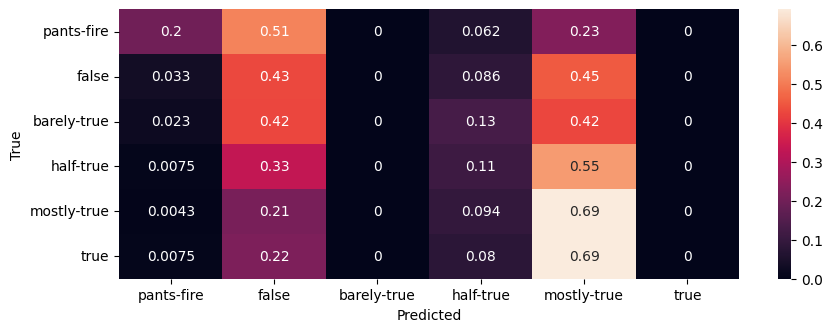

Class(es) with lowest f1 score: barely-true
Example statements:
['The White House promised us that all the spending would keep unemployment under 8 percent. economy stimulus michele-bachmann Congresswoman Minnesota #DT NNP NNP VBD PRP IN PDT DT NN MD VB NN IN CD NN . NN JJ JJ NNP NNP', 'Residents could have received nearly $48M for Local Schools, Fire District, Sheriffs Dept. and Social Services. county-government freedom-and-responsibility-pac  Oregon #NNS MD VB VBN RB $ CD IN JJ NNP , NNP NNP , NNP NNP . CC NNP NNPS . JJ JJ NN', 'Says in 2003 Texas cut $10 billion out of the entire budget, yet we put $1.8 billion more into public education. We put $800 million more into health and human services. state-budget rick-perry Governor Texas #VBZ IN CD NNP VBD $ CD CD IN IN DT JJ NN , RB PRP VBD $ CD CD JJR IN JJ NN . PRP VBD $ CD CD JJR IN NN CC JJ NNS . JJ JJ NNP NNP']
Class(es) with lowest f1 score: true
Example statements:
['Says he would be first CPA to serve as Texas comptroller. stat

In [ ]:
evaluate_model_concatPOS_input(bert_concat_CLS_model_6class_POS, bert_concat_CLS_model_6class_POS_history, train_encodings_POS, train_labels, test_encodings_POS, test_labels)

In [ ]:
bert_concat_CLS_model_6class_POS.save(checkpoint_dir + 'bert_concat_CLS_model_6class_POS')

#### BERT claim + emoLex/LIWC

In [ ]:
def create_bert_pooler_emo_LIWC_model(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the EmoLex features
    emoLex_input = tf.keras.Input(shape=(10,), name='emoLex_features')

    # # Define an additional input layer for the EmoLex features
    LIWC_input = tf.keras.Input(shape=(119,), name='LIWC_features')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    concatenated_output = tf.concat([pooler_token, emoLex_input, LIWC_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emoLex_input, LIWC_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
def create_bert_CLS_emo_LIWC_model(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the EmoLex features
    emoLex_input = tf.keras.Input(shape=(10,), name='emoLex_features')

    # # Define an additional input layer for the EmoLex features
    LIWC_input = tf.keras.Input(shape=(119,), name='LIWC_features')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    concatenated_output = tf.concat([cls_token, emoLex_input, LIWC_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emoLex_input, LIWC_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_baseline_emoLex_LIWC_pooler_model_6class = create_bert_pooler_emo_LIWC_model(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_emoLex_LIWC_pooler_model_6class_history = bert_baseline_emoLex_LIWC_pooler_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, emoLex_train, LIWC_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, emoLex_validate, LIWC_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=6, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
1284/1284 [==============================] - 1075s 818ms/step - loss: 3.7490 - accuracy: 0.1784 - val_loss: 1.9287 - val_accuracy: 0.1936
Epoch 2/2
1284/1284 [==============================] - 1046s 815ms/step - loss: 1.9200 - accuracy: 0.1978 - val_loss: 1.7970 - val_accuracy: 0.1928


Learning Curve


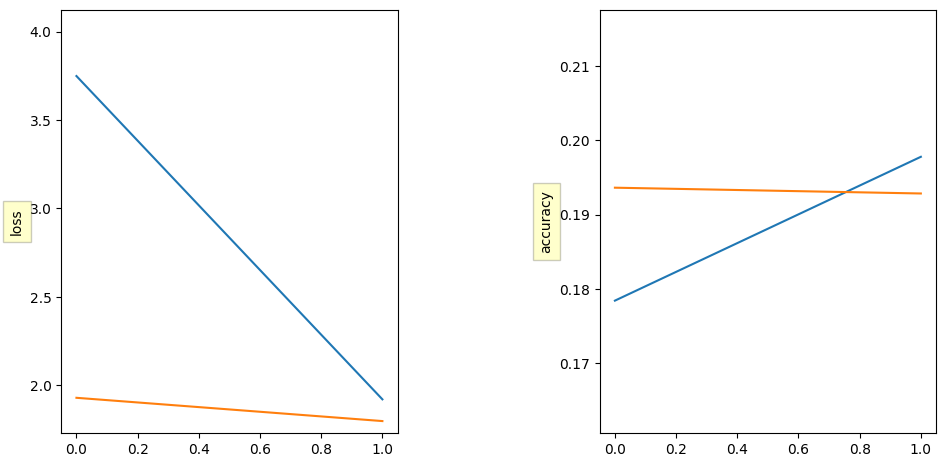

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.05      0.01      0.02       211
       false       0.19      0.16      0.17       523
 barely-true       0.17      0.20      0.18       429
   half-true       0.21      0.33      0.25       534
 mostly-true       0.24      0.22      0.23       469
        true       0.15      0.10      0.12       402

    accuracy                           0.19      2568
   macro avg       0.17      0.17      0.16      2568
weighted avg       0.18      0.19      0.18      2568

Confusion matrix


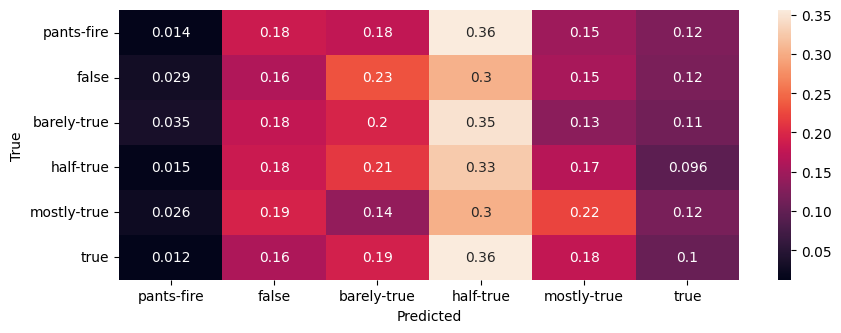

Class(es) with lowest f1 score: pants-fire
Example statements:
['The Obama Administration wants to have soldiers and officers pledge a loyalty oath directly to the office of the President, and no longer to the Constitution.', 'Austin is effectively imposing a ban on barbecue restaurants.', 'Says Marco Rubio is the one for an open border.']


In [ ]:
evaluate_model_claim_features(bert_baseline_emoLex_LIWC_pooler_model_6class, bert_baseline_emoLex_LIWC_pooler_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, emoLex_test, LIWC_test)

In [ ]:
bert_baseline_emoLex_LIWC_pooler_model_6class.save(checkpoint_dir + 'bert_baseline_emoLex_LIWC_pooler_model_6class')

In [ ]:
bert_baseline_emoLex_LIWC_CLS_model_6class = create_bert_CLS_emo_LIWC_model(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_emoLex_LIWC_CLS_model_6class_history = bert_baseline_emoLex_LIWC_CLS_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, emoLex_train, LIWC_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, emoLex_validate, LIWC_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1051s 1s/step - loss: 3.4235 - accuracy: 0.1857 - val_loss: 1.9461 - val_accuracy: 0.2018
Epoch 2/2
963/963 [==============================] - 1020s 1s/step - loss: 1.9237 - accuracy: 0.2230 - val_loss: 1.7914 - val_accuracy: 0.2228


Learning Curve


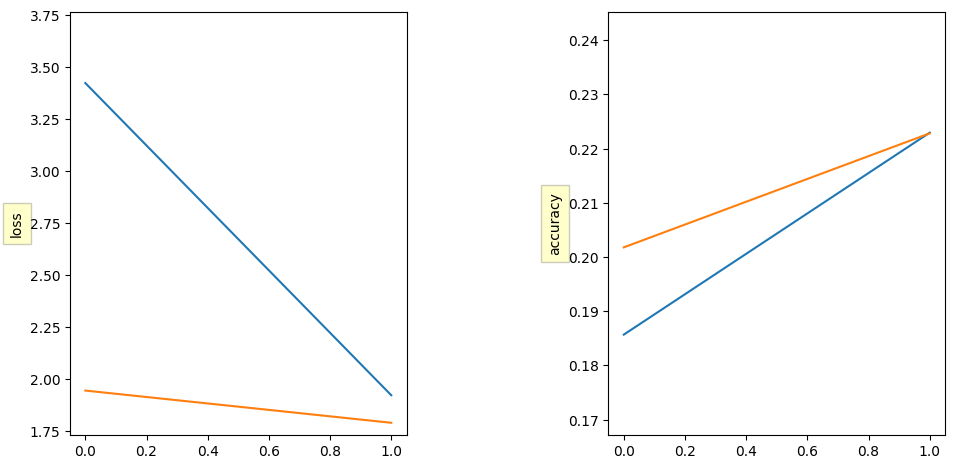

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.28      0.04      0.07       211
       false       0.30      0.19      0.23       523
 barely-true       0.21      0.17      0.19       429
   half-true       0.23      0.31      0.26       534
 mostly-true       0.22      0.24      0.23       469
        true       0.17      0.27      0.21       402

    accuracy                           0.22      2568
   macro avg       0.24      0.20      0.20      2568
weighted avg       0.23      0.22      0.21      2568

Confusion matrix


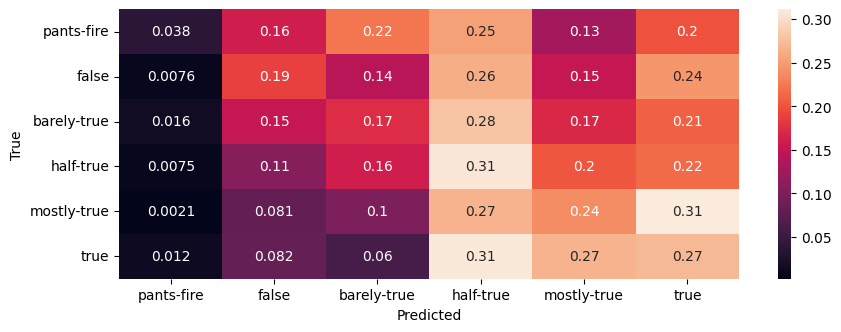

Class(es) with lowest f1 score: pants-fire
Example statements:
['A few months into office, (President Barack Obama) traveled around the globe to apologize for America.', 'Says the word Dhimmitude is on page 107 of the health care law and means Muslims are specifically exempted from the government mandate to purchase insurance.', 'Until the new Iran deal, China and Russia have never voted with us at the U.N. on any sanctions on Iran in the past.']


In [ ]:
evaluate_model_claim_features(bert_baseline_emoLex_LIWC_CLS_model_6class, bert_baseline_emoLex_LIWC_CLS_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, emoLex_test, LIWC_test)

In [ ]:
bert_baseline_emoLex_LIWC_CLS_model_6class.save(checkpoint_dir + 'bert_baseline_emoLex_LIWC_CLS_model_6class')

#### BERT baseline + extreme emotion

In [ ]:
def create_bert_pooler_emotion(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the emotion features
    emotion_input = tf.keras.Input(shape=(12,), name='emotion_features')


    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    concatenated_output = tf.concat([pooler_token, emotion_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emotion_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
def create_bert_CLS_emotion(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the emotion features
    emotion_input = tf.keras.Input(shape=(12,), name='emotion_features')


    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    concatenated_output = tf.concat([cls_token, emotion_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emotion_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_baseline_extreme_emotion_pooler_model_6class = create_bert_pooler_emotion(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_extreme_emotion_pooler_model_6class_history = bert_baseline_extreme_emotion_pooler_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, extreme_emotion_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, extreme_emotion_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1090s 1s/step - loss: 1.7945 - accuracy: 0.1995 - val_loss: 1.7624 - val_accuracy: 0.1718
Epoch 2/2
963/963 [==============================] - 1027s 1s/step - loss: 1.7408 - accuracy: 0.2230 - val_loss: 1.7431 - val_accuracy: 0.2220


Learning Curve


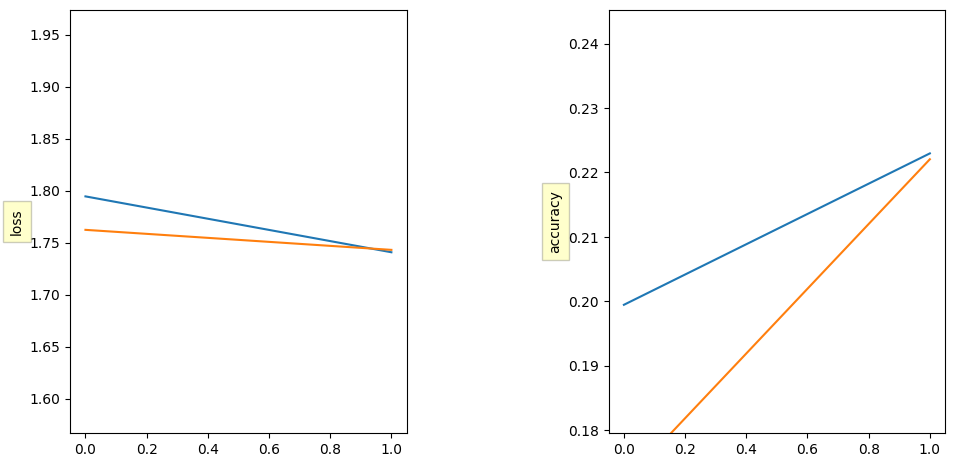

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.23      0.43      0.30       523
 barely-true       0.19      0.48      0.27       429
   half-true       0.30      0.01      0.01       534
 mostly-true       0.29      0.24      0.26       469
        true       0.26      0.09      0.13       402

    accuracy                           0.23      2568
   macro avg       0.21      0.21      0.16      2568
weighted avg       0.24      0.23      0.18      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


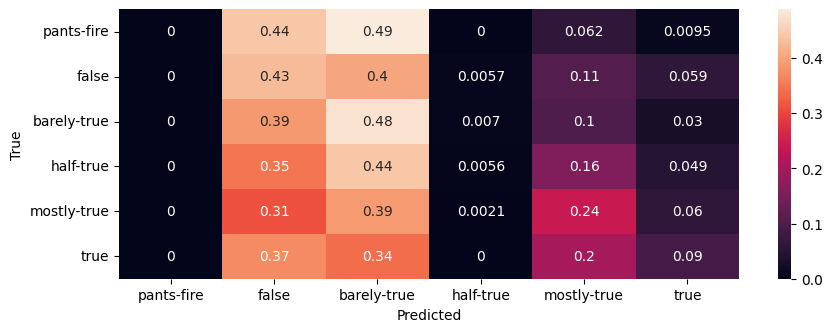

Class(es) with lowest f1 score: pants-fire
Example statements:
['"Page 92 of the House health care bill ""says specifically that people can\'t purchase private health insurance after a date certain."""', '"Obama says America is great, but let\'s ""try to change it."""', 'Says Baltimore police are trained by Mossad and Shin Bet.']


In [ ]:
evaluate_model_claim_features2(bert_baseline_extreme_emotion_pooler_model_6class, bert_baseline_extreme_emotion_pooler_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, extreme_emotion_test)

In [ ]:
bert_baseline_extreme_emotion_CLS_model_6class = create_bert_CLS_emotion(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_extreme_emotion_CLS_model_6class_history = bert_baseline_extreme_emotion_CLS_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, extreme_emotion_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, extreme_emotion_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1049s 1s/step - loss: 1.8198 - accuracy: 0.1898 - val_loss: 1.7585 - val_accuracy: 0.1991
Epoch 2/2
963/963 [==============================] - 1025s 1s/step - loss: 1.7704 - accuracy: 0.1905 - val_loss: 1.7560 - val_accuracy: 0.2057


Learning Curve


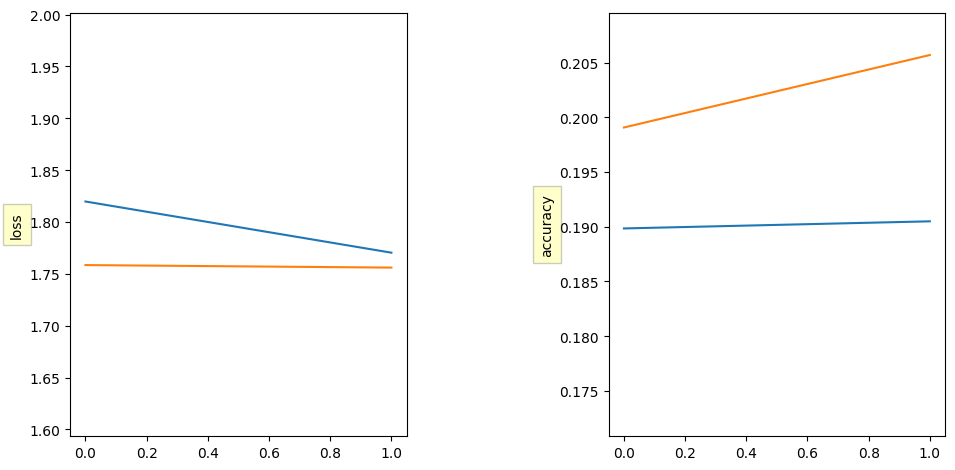

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.20      0.18      0.19       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.21      0.83      0.34       534
 mostly-true       0.00      0.00      0.00       469
        true       0.00      0.00      0.00       402

    accuracy                           0.21      2568
   macro avg       0.07      0.17      0.09      2568
weighted avg       0.08      0.21      0.11      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


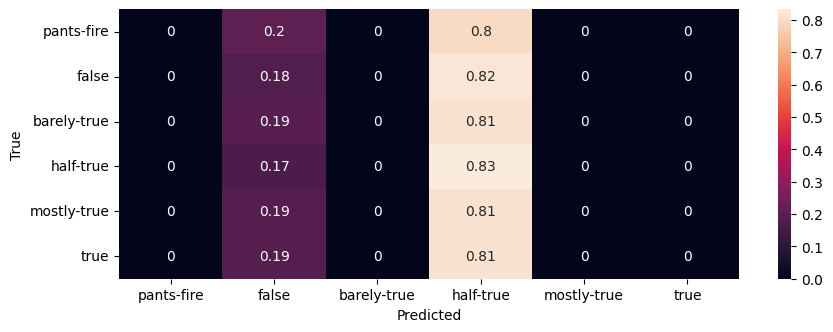

Class(es) with lowest f1 score: pants-fire
Example statements:
['Says Chuck Hagels nomination as defense secretary has been publicly celebrated by the Iranian government.', 'Congressman Robert Hurt has a plan to cut education by 40 percent.', 'The fact that one town has three lanes dedicated to it, that kind of gets me sauced.']
Class(es) with lowest f1 score: barely-true
Example statements:
['From 2014 to 2015, Austins murder rate is up a whopping 83 percent.', 'Says he stood up to his own party by voting against the budget to stop runaway government spending.', 'Youre paying for...(state Sen. Diane Allens) health care, and she took yours away.']
Class(es) with lowest f1 score: mostly-true
Example statements:
['TriMet is spending 4.2 million in fed funds to save $168K per year.', "We're spending $1.6 billion for all of Latin America in terms of aid and assistance, a fraction of what we're spending in Iraq, the $500 billion we've spent there", 'When Republicans last controlled the pres

In [ ]:
evaluate_model_claim_features2(bert_baseline_extreme_emotion_CLS_model_6class, bert_baseline_extreme_emotion_CLS_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, extreme_emotion_test)

#### BERT concat + extreme emotions

In [ ]:
bert_concat_extreme_emotion_pooler_model_6class = create_bert_pooler_emotion(checkpoint=model_checkpoint, num_classes=6)
bert_concat_extreme_emotion_pooler_model_6class_history = bert_concat_extreme_emotion_pooler_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, extreme_emotion_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, extreme_emotion_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1023s 1s/step - loss: 1.8163 - accuracy: 0.1930 - val_loss: 1.7441 - val_accuracy: 0.2061
Epoch 2/2
963/963 [==============================] - 993s 1s/step - loss: 1.7484 - accuracy: 0.2256 - val_loss: 1.7557 - val_accuracy: 0.1866


Learning Curve


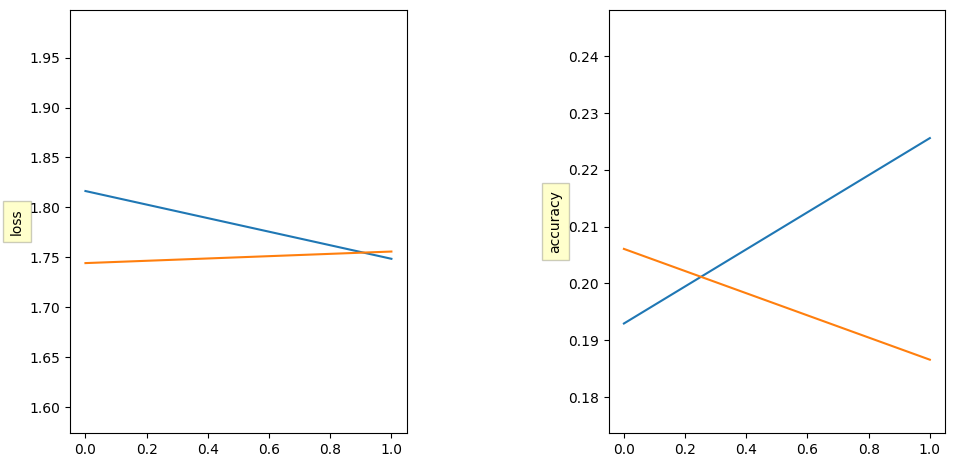

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.19      0.66      0.30       211
       false       0.23      0.24      0.23       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.25      0.05      0.08       534
 mostly-true       0.26      0.19      0.22       469
        true       0.20      0.43      0.28       402

    accuracy                           0.21      2568
   macro avg       0.19      0.26      0.18      2568
weighted avg       0.19      0.21      0.17      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


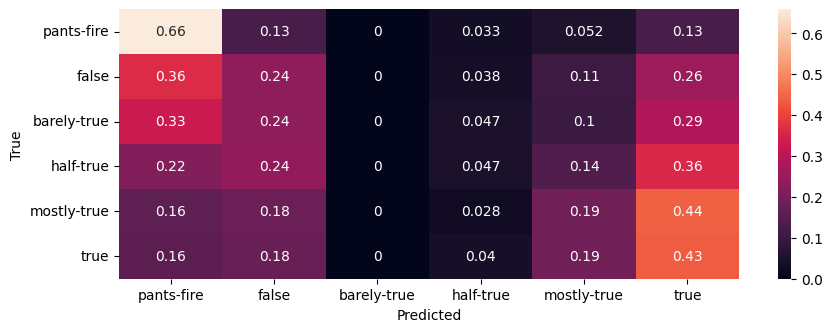

Class(es) with lowest f1 score: barely-true
Example statements:
['Says Scott Brown co-sponsored legislationto let employers deny women coverage formammograms.', 'Says Scott Walkers jobs agency gives financial incentives that lead Wisconsin companies to look at shipping jobs elsewhere. ... A company got $4.6 million in taxpayer money and actually reduced its jobs by 300 people.', 'The debt limit deal allows President Obama to borrow unlimited amounts of money.']


In [ ]:
evaluate_model_claim_features2(bert_concat_extreme_emotion_pooler_model_6class, bert_concat_extreme_emotion_pooler_model_6class_history, train_encodings, train_labels, test_encodings, test_labels, extreme_emotion_test)

In [ ]:
bert_concat_extreme_emotion_CLS_model_6class = create_bert_CLS_emotion(checkpoint=model_checkpoint, num_classes=6)
bert_concat_extreme_emotion_CLS_model_6class_history = bert_concat_extreme_emotion_CLS_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, extreme_emotion_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, extreme_emotion_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1009s 1s/step - loss: 1.7695 - accuracy: 0.2182 - val_loss: 1.7153 - val_accuracy: 0.2069
Epoch 2/2
963/963 [==============================] - 989s 1s/step - loss: 1.6934 - accuracy: 0.2469 - val_loss: 1.6893 - val_accuracy: 0.2657


Learning Curve


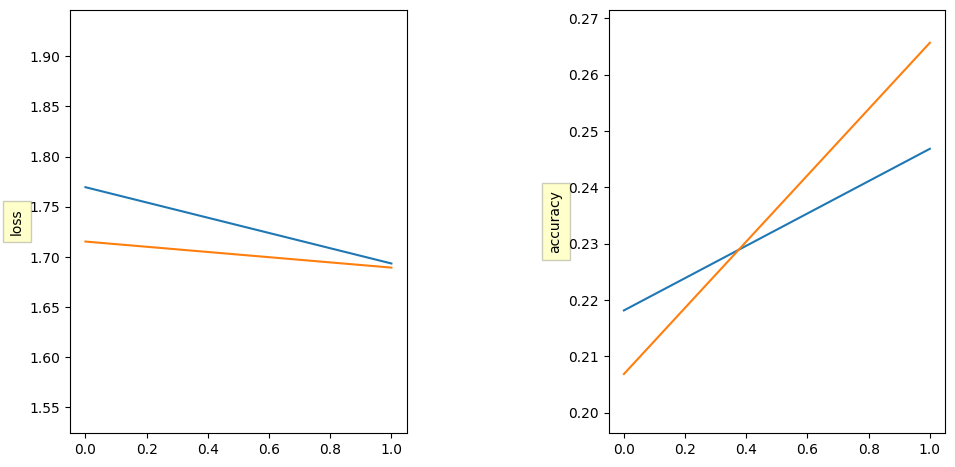

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.56      0.09      0.16       211
       false       0.27      0.45      0.34       523
 barely-true       0.19      0.07      0.10       429
   half-true       0.24      0.36      0.29       534
 mostly-true       0.28      0.43      0.34       469
        true       0.00      0.00      0.00       402

    accuracy                           0.26      2568
   macro avg       0.26      0.23      0.21      2568
weighted avg       0.23      0.26      0.22      2568

Confusion matrix


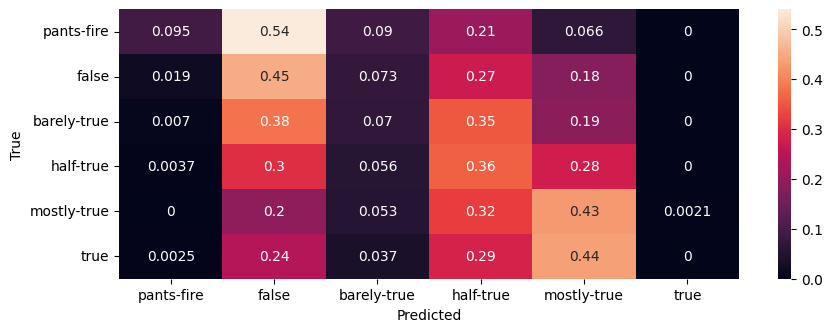

Class(es) with lowest f1 score: true
Example statements:
['(Hillary Clintons State Department) actually admonished one of her ambassadors because he wasnt using the proper server.', 'While introducing Donald Trump, former New York City Mayor Rudy Giuliani omitted the September 11, 2001, strikes as a successful terrorist attack during the eight years before President Obamas 2008 election.', 'Says Multnomah County libraries are open 44 hours per week the lowest of any library in the four-county region.']


In [ ]:
evaluate_model_claim_features2(bert_concat_extreme_emotion_CLS_model_6class, bert_concat_extreme_emotion_CLS_model_6class_history, train_encodings, train_labels, test_encodings, test_labels, extreme_emotion_test)

#### BERT baseline + positive conotations

In [ ]:
def create_bert_pooler_positive(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the emotion features
    emotion_input = tf.keras.Input(shape=(4,), name='emotion_features')


    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    concatenated_output = tf.concat([pooler_token, emotion_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emotion_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
def create_bert_CLS_positive(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the emotion features
    emotion_input = tf.keras.Input(shape=(4,), name='emotion_features')


    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    concatenated_output = tf.concat([cls_token, emotion_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emotion_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_baseline_positive_pooler_model_6class = create_bert_pooler_positive(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_positive_pooler_model_6class_history = bert_baseline_positive_pooler_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, positive_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, positive_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1021s 1s/step - loss: 1.7976 - accuracy: 0.1909 - val_loss: 1.7556 - val_accuracy: 0.2030
Epoch 2/2
963/963 [==============================] - 984s 1s/step - loss: 1.7671 - accuracy: 0.1974 - val_loss: 1.7535 - val_accuracy: 0.2022


Learning Curve


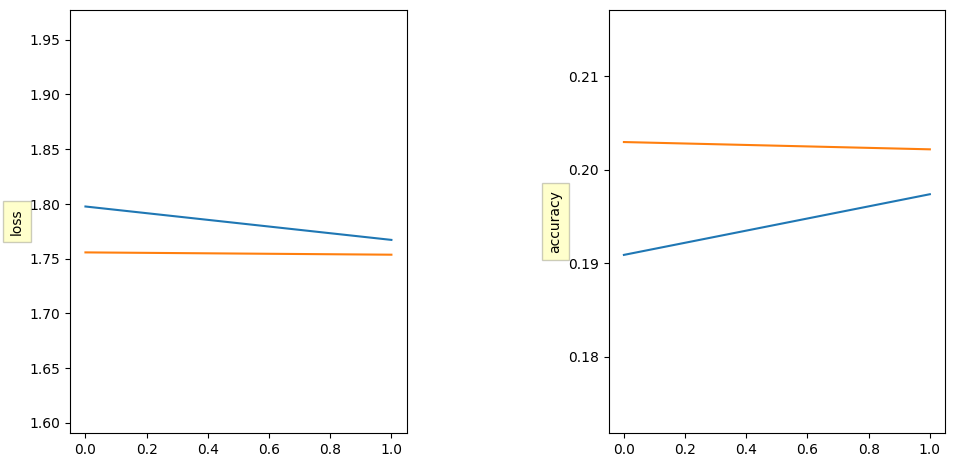

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.18      0.00      0.01       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.21      0.99      0.34       534
 mostly-true       0.18      0.00      0.01       469
        true       0.00      0.00      0.00       402

    accuracy                           0.21      2568
   macro avg       0.10      0.17      0.06      2568
weighted avg       0.11      0.21      0.07      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


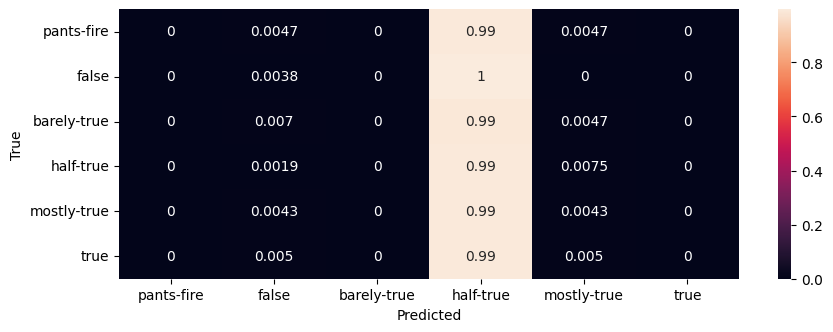

Class(es) with lowest f1 score: pants-fire
Example statements:
['Foreign Chinese prostitution money is allegedly behind the groups funding Congressman Sean Duffys Republican Majority.', 'Theres talk in Congress now about basically confiscating your private 401(k) or IRA plan and rolling it into Social Security to strengthen Social Security.', '"My ""border security efforts have led to a 60 percent decrease in border crime."""']
Class(es) with lowest f1 score: barely-true
Example statements:
['"The White House has ""refused"" international help in dealing with the oil spill."', 'Obamas flush with cash, returning to Wall Street for even more money. Wall Street sure supports President Obama.', 'Since 1978, California has spent $5 billion to put 13 people to death.']
Class(es) with lowest f1 score: true
Example statements:
['Since 1900, six (U.S. Supreme Court) justices have been confirmed during election years, including Justice Anthony Kennedy, who was confirmed in the final year of the 

In [ ]:
evaluate_model_claim_features2(bert_baseline_positive_pooler_model_6class, bert_baseline_positive_pooler_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, positive_test)


In [ ]:
bert_baseline_positive_CLS_model_6class = create_bert_CLS_positive(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_positive_CLS_model_6class_history = bert_baseline_positive_CLS_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, positive_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, positive_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1059s 1s/step - loss: 1.7655 - accuracy: 0.2172 - val_loss: 1.7292 - val_accuracy: 0.2345
Epoch 2/2
963/963 [==============================] - 1024s 1s/step - loss: 1.7121 - accuracy: 0.2469 - val_loss: 1.7764 - val_accuracy: 0.2396


Learning Curve


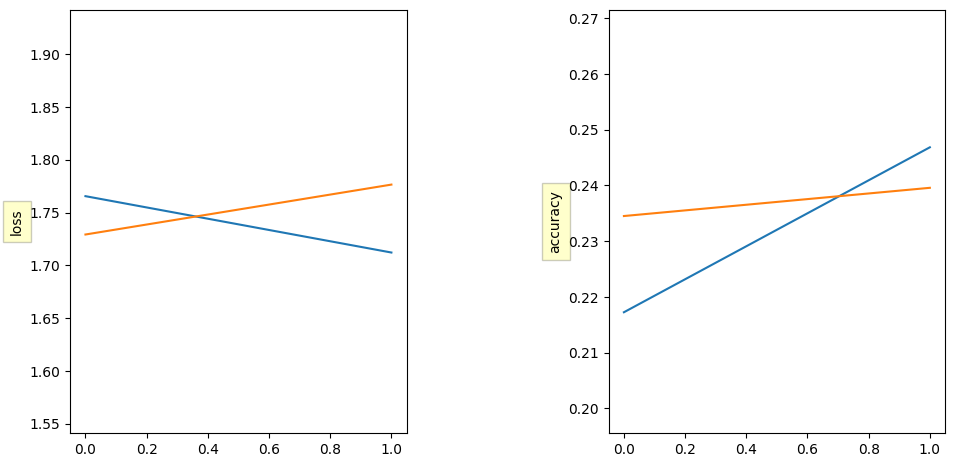

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.19      0.37      0.25       211
       false       0.23      0.45      0.31       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.30      0.16      0.21       534
 mostly-true       0.27      0.47      0.35       469
        true       0.35      0.08      0.13       402

    accuracy                           0.25      2568
   macro avg       0.23      0.25      0.21      2568
weighted avg       0.23      0.25      0.21      2568

Confusion matrix


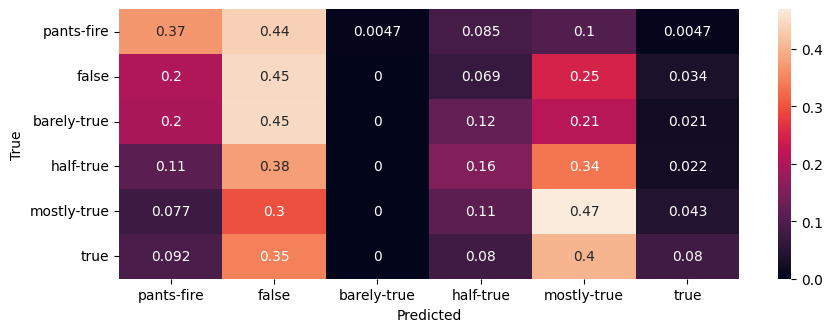

Class(es) with lowest f1 score: barely-true
Example statements:
['Says a Barack Obama black imposter joke got a standing ovation at San Angelo rodeo.', 'Tim Kaine made Virginia the best state for business four years in a row.', 'Says Hillary Clinton takes tens of millions of dollars from countries that hate women, that disrespect women, that throw gays off of buildings.']


In [ ]:
evaluate_model_claim_features2(bert_baseline_positive_CLS_model_6class, bert_baseline_positive_CLS_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, positive_test)

#### BERT concat + positive conotations

In [ ]:
bert_concat_positive_pooler_model_6class = create_bert_pooler_positive(checkpoint=model_checkpoint, num_classes=6)
bert_concat_positive_pooler_model_6class_history = bert_concat_positive_pooler_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, positive_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, positive_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1045s 1s/step - loss: 1.7910 - accuracy: 0.1887 - val_loss: 1.7647 - val_accuracy: 0.2030
Epoch 2/2
963/963 [==============================] - 1024s 1s/step - loss: 1.7712 - accuracy: 0.2045 - val_loss: 1.7642 - val_accuracy: 0.2026


Learning Curve


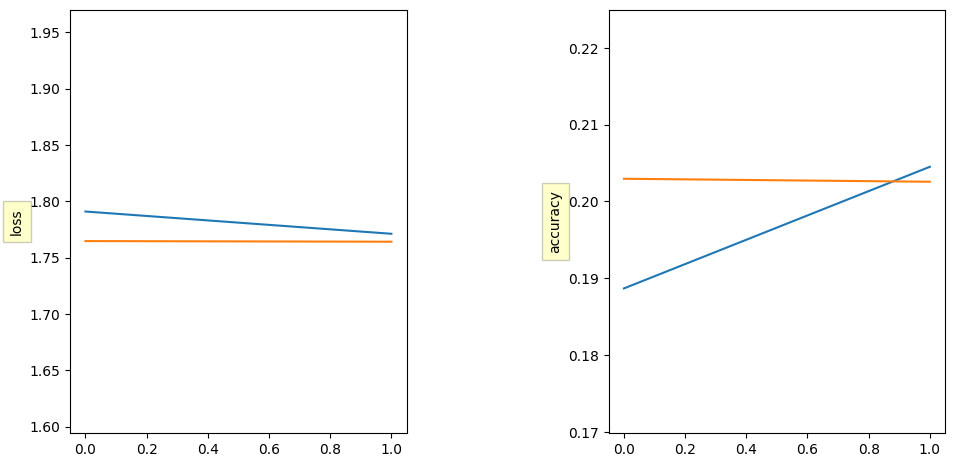

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.00      0.00      0.00       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.21      1.00      0.34       534
 mostly-true       0.00      0.00      0.00       469
        true       0.00      0.00      0.00       402

    accuracy                           0.21      2568
   macro avg       0.03      0.17      0.06      2568
weighted avg       0.04      0.21      0.07      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


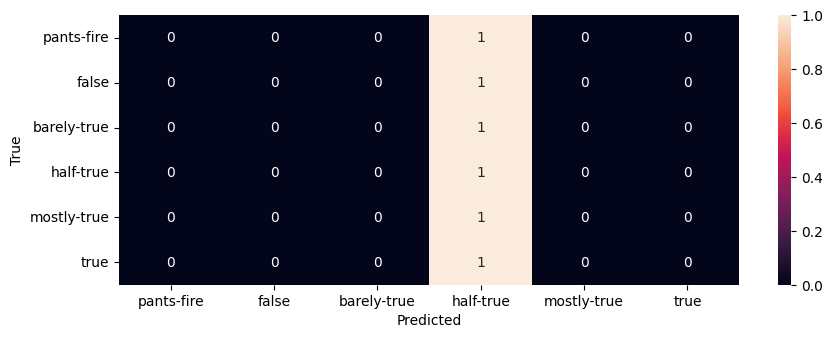

Class(es) with lowest f1 score: pants-fire
Example statements:
['President Obama has the lowest public approval ratings of any president in modern times.', 'Congressman Kasich wants to use our tax dollars to give secret bonuses to his corporate friends.', 'Recently Rick Scott closed 30 womens health care centers across the state.']
Class(es) with lowest f1 score: false
Example statements:
['Says Gov. Scott Walkers repeal of a 2009 law has left Wisconsin as one of five states without an equal pay law protecting women from gender discrimination in their paycheck.', 'Over 200 years ago, the United States had declared war on Islam, and Thomas Jefferson led the charge!', 'Theres a mosque inside of the Pentagon.']
Class(es) with lowest f1 score: barely-true
Example statements:
['Says Proposition 205 blocks market entry for new marijuana dispensaries.', 'As governor, Mitt Romney raised nursing home fees eight times.', 'Says someone earning $50,000 a year will fare better under his 9-9-9 plan 

In [ ]:
evaluate_model_claim_features2(bert_concat_positive_pooler_model_6class, bert_concat_positive_pooler_model_6class_history, train_encodings, train_labels, test_encodings, test_labels, positive_test)

In [ ]:
bert_concat_positive_CLS_model_6class = create_bert_CLS_positive(checkpoint=model_checkpoint, num_classes=6)
bert_concat_positive_CLS_model_6class_history = bert_concat_positive_CLS_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, positive_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, positive_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1048s 1s/step - loss: 1.7605 - accuracy: 0.2206 - val_loss: 1.7267 - val_accuracy: 0.2505
Epoch 2/2
963/963 [==============================] - 1026s 1s/step - loss: 1.7413 - accuracy: 0.2337 - val_loss: 1.7826 - val_accuracy: 0.2252


Learning Curve


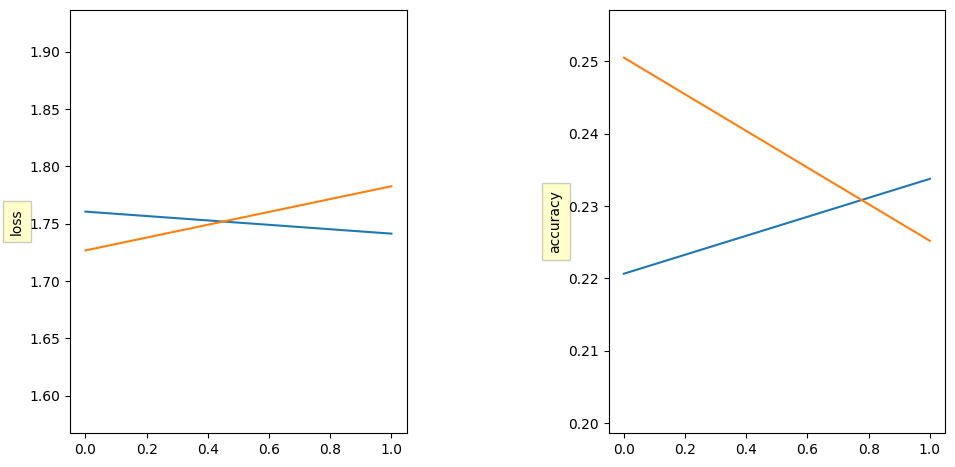

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.61      0.13      0.22       211
       false       0.23      0.10      0.13       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.19      0.06      0.09       534
 mostly-true       0.20      0.92      0.33       469
        true       0.00      0.00      0.00       402

    accuracy                           0.21      2568
   macro avg       0.21      0.20      0.13      2568
weighted avg       0.17      0.21      0.13      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


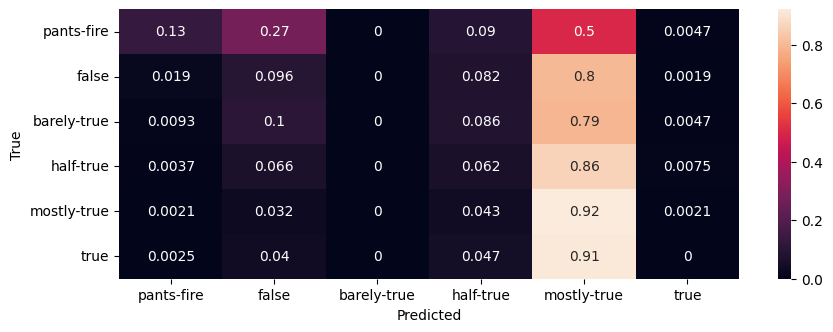

Class(es) with lowest f1 score: barely-true
Example statements:
['Tea Party Congressman Frank Guinta voted for billions in cuts to veterans programs.', 'Charlie Crists personal approval numbers are plummeting.', 'Congressman Bill Young voted to cut taxes for millionaires and end your Medicare.']
Class(es) with lowest f1 score: true
Example statements:
['"In a now-viral video, ""impressionable youngsters at a public school in New Jersey ... have been instructed to sing the praises of \'Barack Hussein Obama.\'"""', 'We were the No. 1 job creator in America in February and we are now the No. 4 job creator in the last year.', 'The debt will soon eclipse our entire economy.']


In [ ]:
evaluate_model_claim_features2(bert_concat_positive_CLS_model_6class, bert_concat_positive_CLS_model_6class_history, train_encodings, train_labels, test_encodings, test_labels, positive_test)

#### BERT baseline + negative conotation

In [ ]:
def create_bert_pooler_negative(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the emotion features
    emotion_input = tf.keras.Input(shape=(10,), name='emotion_features')


    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    concatenated_output = tf.concat([pooler_token, emotion_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emotion_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
def create_bert_CLS_negative(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    if num_classes == 2:
      activation_fn = 'sigmoid'
      loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    else:
      activation_fn = 'softmax'
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    
    # claim BERT input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int64, name='attention_mask_layer')

    # Define an additional input layer for the emotion features
    emotion_input = tf.keras.Input(shape=(10,), name='emotion_features')


    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    concatenated_output = tf.concat([cls_token, emotion_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, emotion_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_baseline_negative_pooler_model_6class = create_bert_pooler_negative(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_negative_pooler_model_6class_history = bert_baseline_negative_pooler_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, negative_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, negative_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1042s 1s/step - loss: 1.7920 - accuracy: 0.2032 - val_loss: 1.7287 - val_accuracy: 0.2411
Epoch 2/2
963/963 [==============================] - 1025s 1s/step - loss: 1.7337 - accuracy: 0.2249 - val_loss: 1.7144 - val_accuracy: 0.2380


Learning Curve


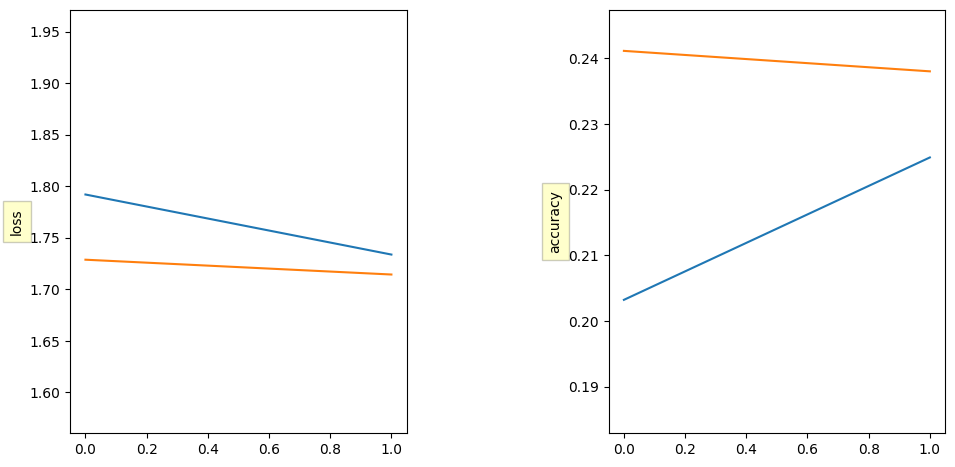

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.28      0.27      0.27       523
 barely-true       0.00      0.00      0.00       429
   half-true       0.22      0.52      0.31       534
 mostly-true       0.26      0.43      0.32       469
        true       0.00      0.00      0.00       402

    accuracy                           0.24      2568
   macro avg       0.13      0.20      0.15      2568
weighted avg       0.15      0.24      0.18      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


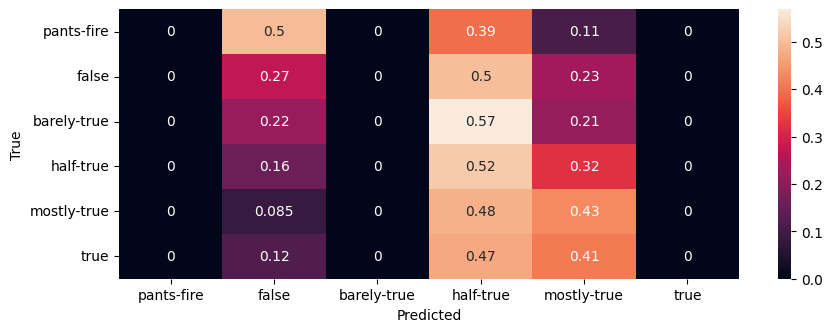

Class(es) with lowest f1 score: pants-fire
Example statements:
['Sheila Jackson Lee of Texas said: Hey, all you wrinkly, white-aged has-beens: Its time for you to die and let the next generation have your spot on the planet.', 'Claims credit for food tax reductions that previous Democrat regimes refused to make.', '"Blue Cross headquarters has ""a $30,000 granite table."""']
Class(es) with lowest f1 score: barely-true
Example statements:
['During my administration, for example, we boosted U.S. exports to Canada and Mexico by about 50 percent. That supports about 2.8 million American jobs.', 'I have not insulted Donald personally.', 'When Congressman Langevin took office, gas was around $1.70 per gallon, and now it is near $4 per gallon.']
Class(es) with lowest f1 score: true
Example statements:
['Illinois suffered 1,652 overdose deaths in 2014 ... of which 40 percent were associated with heroin. Illinois is ranked number one in the nation for a decline in treatment capacity between 200

In [ ]:
evaluate_model_claim_features2(bert_baseline_negative_pooler_model_6class, bert_baseline_negative_pooler_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, negative_test)

In [ ]:
bert_baseline_negative_CLS_model_6class = create_bert_CLS_negative(checkpoint=model_checkpoint, num_classes=6)
bert_baseline_negative_CLS_model_6class_history = bert_baseline_negative_CLS_model_6class.fit(
    [train_encodings_claim.input_ids, train_encodings_claim.token_type_ids, train_encodings_claim.attention_mask, negative_train], 
    train_labels,   
    validation_data=(
        [valid_encodings_claim.input_ids, valid_encodings_claim.token_type_ids, valid_encodings_claim.attention_mask, negative_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1044s 1s/step - loss: 1.7655 - accuracy: 0.2117 - val_loss: 1.7145 - val_accuracy: 0.2485
Epoch 2/2
963/963 [==============================] - 1024s 1s/step - loss: 1.6887 - accuracy: 0.2620 - val_loss: 1.7177 - val_accuracy: 0.2443


Learning Curve


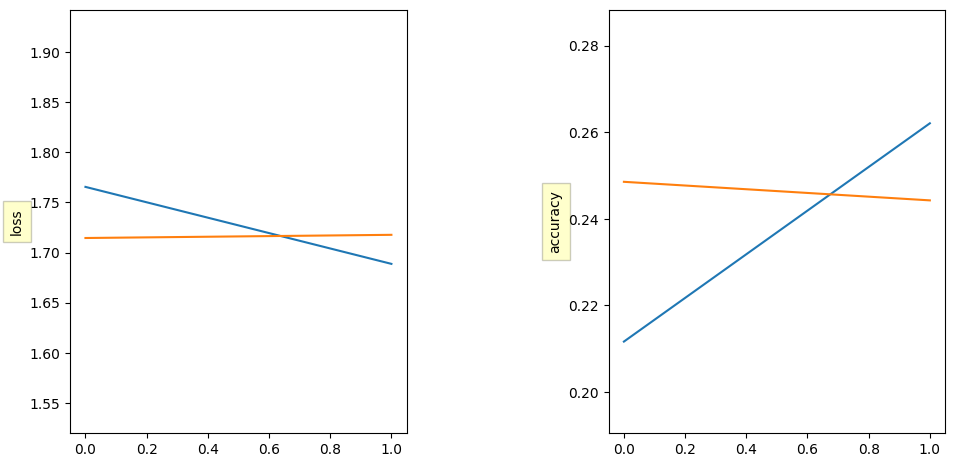

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.19      0.34      0.24       211
       false       0.26      0.24      0.25       523
 barely-true       0.20      0.20      0.20       429
   half-true       0.57      0.01      0.01       534
 mostly-true       0.24      0.63      0.35       469
        true       0.14      0.02      0.03       402

    accuracy                           0.23      2568
   macro avg       0.27      0.24      0.18      2568
weighted avg       0.29      0.23      0.18      2568

Confusion matrix


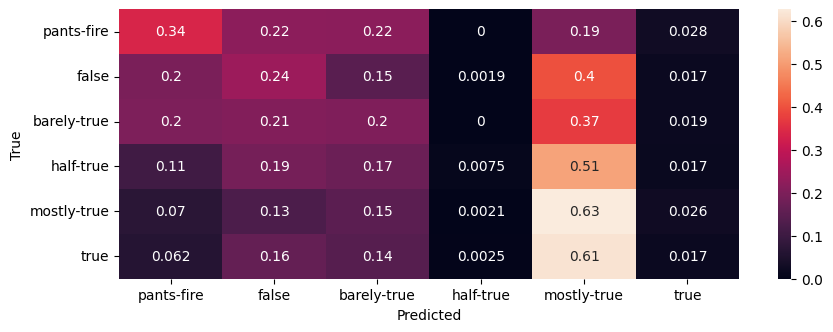

Class(es) with lowest f1 score: half-true
Example statements:
['Says he has repeatedly praised Chuck Hagels character, patriotism, bravery, and personal service defending our nation.', 'Says Mitt Romney flip-flopped on an assault weapons ban.', 'Says Tommy Thompson pushed such strict laws that abortion providers faced potential life imprisonment and women were forced to cross state lines in order to receive attention for life-threatening issues.']


In [ ]:
evaluate_model_claim_features2(bert_baseline_negative_CLS_model_6class, bert_baseline_negative_CLS_model_6class_history, train_encodings_claim, train_labels, test_encodings_claim, test_labels, negative_test)

#### BERT concat + negative conotation

In [ ]:
bert_concat_negative_pooler_model_6class = create_bert_pooler_negative(checkpoint=model_checkpoint, num_classes=6)
bert_concat_negative_pooler_model_6class_history = bert_concat_negative_pooler_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, negative_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, negative_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1048s 1s/step - loss: 1.7921 - accuracy: 0.1915 - val_loss: 1.7390 - val_accuracy: 0.2220
Epoch 2/2
963/963 [==============================] - 1025s 1s/step - loss: 1.7289 - accuracy: 0.2339 - val_loss: 1.7770 - val_accuracy: 0.1991


Learning Curve


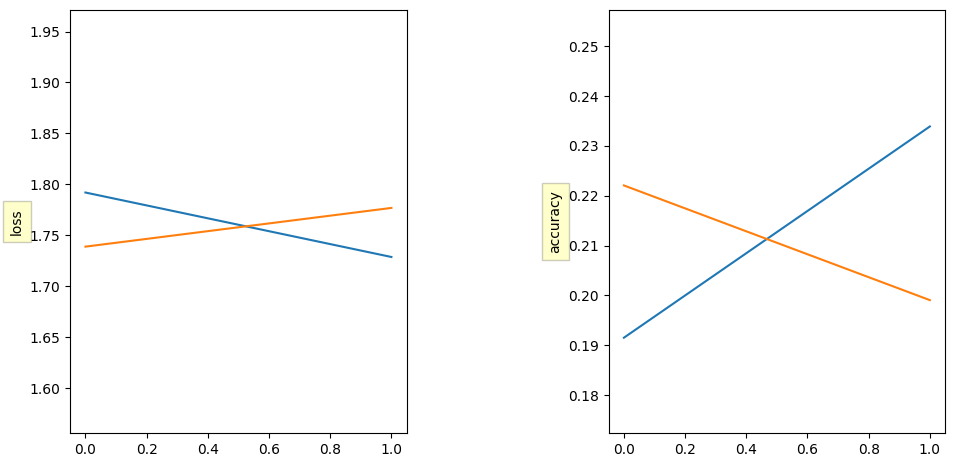

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       211
       false       0.20      1.00      0.34       523
 barely-true       1.00      0.00      0.00       429
   half-true       0.00      0.00      0.00       534
 mostly-true       0.00      0.00      0.00       469
        true       0.00      0.00      0.00       402

    accuracy                           0.20      2568
   macro avg       0.20      0.17      0.06      2568
weighted avg       0.21      0.20      0.07      2568

Confusion matrix


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


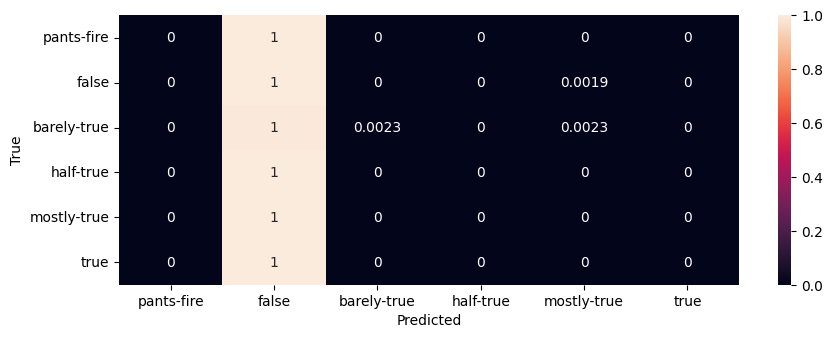

Class(es) with lowest f1 score: pants-fire
Example statements:
['They talk about this problem with binding arbitration. It doesnt make a lot of sense to me to have somebody from Los Angeles fly into Zanesville and impose a wage settlement on you ... and then theyre on the plane back to Los Angeles.', 'The federal Hate Crimes Prevention Act bill would create special protection for pedophiles.', 'Forty years ago, hardly anybody in the country had health insurance.']
Class(es) with lowest f1 score: half-true
Example statements:
['Says that since he took office, there have been no large-scale attacks on the United States.', 'On bringing casino gambling and other gaming to Georgia', 'Says Marshawn Lynch is second all-time in terms of average yards per rush only to Terrell Davis.']
Class(es) with lowest f1 score: mostly-true
Example statements:
['Says Fulton County government hasnt raised its millage rate since 1991.', 'Says in Oregon today, the average debt upon college graduation is more t

In [ ]:
evaluate_model_claim_features2(bert_concat_negative_pooler_model_6class, bert_concat_negative_pooler_model_6class_history, train_encodings, train_labels, test_encodings, test_labels, negative_test)

In [ ]:
bert_concat_negative_CLS_model_6class = create_bert_CLS_negative(checkpoint=model_checkpoint, num_classes=6)
bert_concat_negative_CLS_model_6class_history = bert_concat_negative_CLS_model_6class.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, negative_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, negative_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1046s 1s/step - loss: 1.7596 - accuracy: 0.2111 - val_loss: 1.6872 - val_accuracy: 0.2602
Epoch 2/2
963/963 [==============================] - 1027s 1s/step - loss: 1.6803 - accuracy: 0.2606 - val_loss: 1.6892 - val_accuracy: 0.2653


Learning Curve


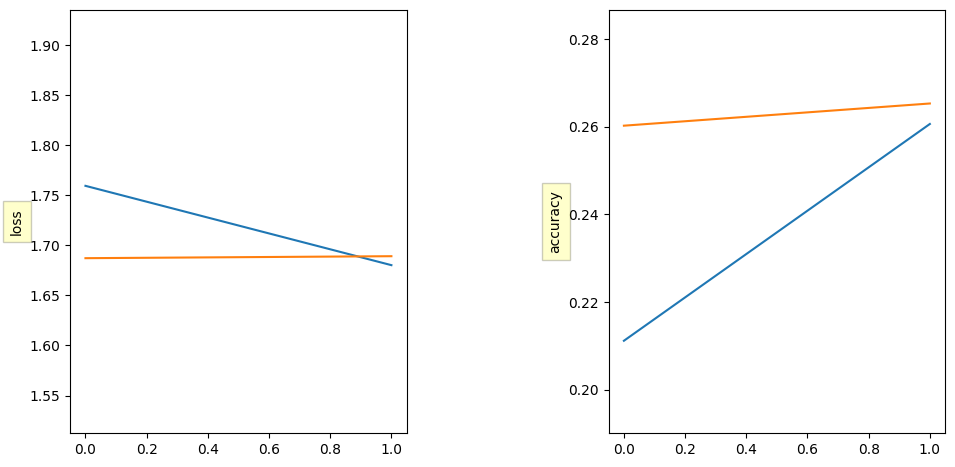

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.55      0.19      0.29       211
       false       0.28      0.32      0.30       523
 barely-true       0.21      0.22      0.21       429
   half-true       0.24      0.48      0.32       534
 mostly-true       0.30      0.19      0.23       469
        true       0.27      0.04      0.07       402

    accuracy                           0.26      2568
   macro avg       0.31      0.24      0.24      2568
weighted avg       0.28      0.26      0.24      2568

Confusion matrix


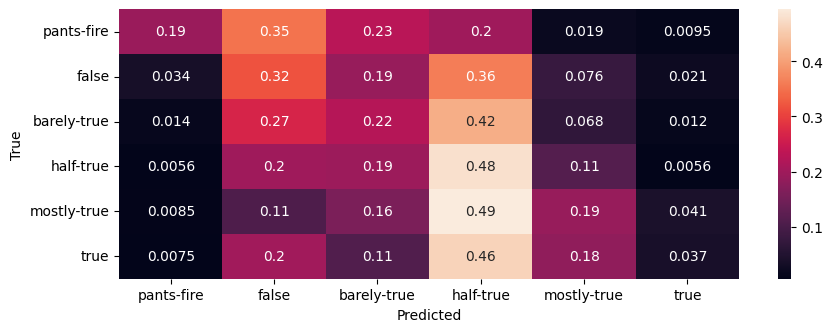

Class(es) with lowest f1 score: true
Example statements:
['In the past decade in New York State more than 30 current and former state officeholders have been convicted, sanctioned or accused of wrongdoing more than any other state.', "This guy didn't even support Ronald Reagan.", 'One in four Texans lacks health insurance, the highest proportion in the nation.']


In [ ]:
evaluate_model_claim_features2(bert_concat_negative_CLS_model_6class, bert_concat_negative_CLS_model_6class_history, train_encodings, train_labels, test_encodings, test_labels, negative_test)

#### BERT concat + emoLex/LIWC

In [ ]:
bert_concat_emo_LIWC_pooler_model = create_bert_pooler_emo_LIWC_model(checkpoint=model_checkpoint, num_classes=6)
bert_concat_emo_LIWC_pooler_model_history = bert_concat_emo_LIWC_pooler_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, emoLex_train, LIWC_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, emoLex_validate, LIWC_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
963/963 [==============================] - 1056s 1s/step - loss: 3.6917 - accuracy: 0.1859 - val_loss: 1.9523 - val_accuracy: 0.2030
Epoch 2/2
963/963 [==============================] - 1022s 1s/step - loss: 1.9481 - accuracy: 0.2056 - val_loss: 1.8041 - val_accuracy: 0.2057


Learning Curve


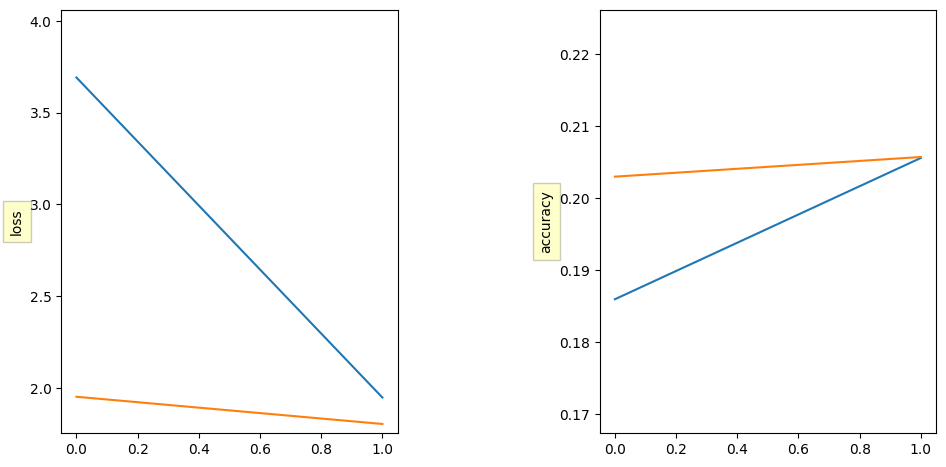

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.05      0.00      0.01       211
       false       0.20      0.21      0.21       523
 barely-true       0.14      0.06      0.09       429
   half-true       0.22      0.30      0.26       534
 mostly-true       0.22      0.32      0.26       469
        true       0.17      0.18      0.17       402

    accuracy                           0.20      2568
   macro avg       0.17      0.18      0.17      2568
weighted avg       0.18      0.20      0.19      2568

Confusion matrix


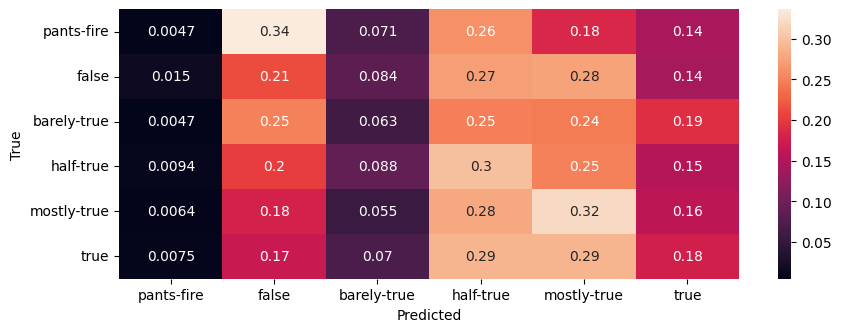

Class(es) with lowest f1 score: pants-fire
Example statements:
['"Over the past few months, we\'ve learned that ""we just can\'t count on the media to debunk"" lies about health insurance reform." health-care pundits organizing-america  ', 'If Buehler were elected, our vote-by-mail system would be at risk. elections message-machine-2012 bill-bradbury  Oregon', 'Says the Obama administration is handing out a pamphlet titled, What To Do When The Veteran In Your Classroom Attempts A Mass Shooting corrections-and-updates education guns military veterans mr-conservative Conservative website None']


In [ ]:
evaluate_model_concat_features(bert_concat_emo_LIWC_pooler_model, bert_concat_emo_LIWC_pooler_model_history, train_encodings, train_labels, test_encodings, test_labels, emoLex_test, LIWC_test)

In [ ]:
bert_concat_emo_LIWC_pooler_model.save(checkpoint_dir + 'bert_concat_emo_LIWC_pooler_model')

In [ ]:
bert_concat_emo_LIWC_CLS_model = create_bert_CLS_emo_LIWC_model(checkpoint=model_checkpoint, num_classes=6)
bert_concat_emo_LIWC_CLS_model_history = bert_concat_emo_LIWC_CLS_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask, emoLex_train, LIWC_train], 
    train_labels,   
    validation_data=(
        [valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask, emoLex_validate, LIWC_validate],  
        np.asarray(validate_labels)
    ),    
    batch_size=8, 
    epochs=2
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


963/963 [==============================] - 1048s 1s/step - loss: 3.6392 - accuracy: 0.1831 - val_loss: 1.9749 - val_accuracy: 0.2022
Epoch 2/2
963/963 [==============================] - 1037s 1s/step - loss: 1.9900 - accuracy: 0.2178 - val_loss: 1.7957 - val_accuracy: 0.2220


Learning Curve


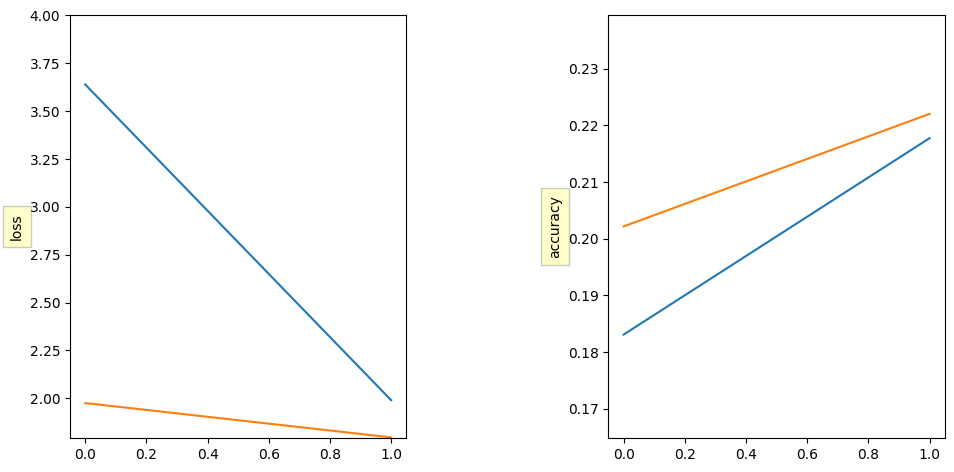

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.23      0.09      0.13       211
       false       0.27      0.20      0.23       523
 barely-true       0.19      0.15      0.17       429
   half-true       0.21      0.25      0.23       534
 mostly-true       0.22      0.36      0.27       469
        true       0.19      0.16      0.17       402

    accuracy                           0.22      2568
   macro avg       0.22      0.20      0.20      2568
weighted avg       0.22      0.22      0.21      2568

Confusion matrix


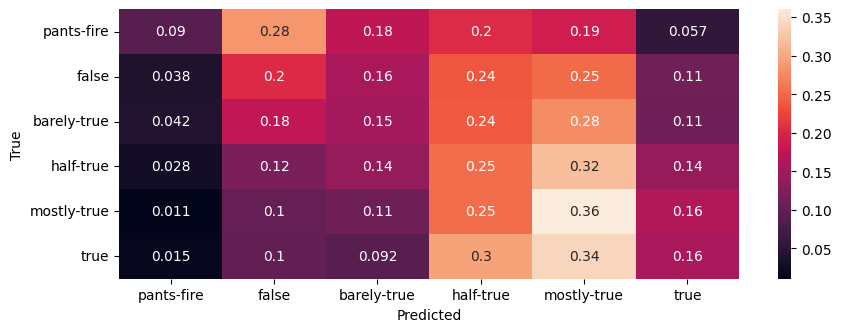

Class(es) with lowest f1 score: pants-fire
Example statements:
['Ninety-four percent of the bills that pass the Senate have no debate, no vote, no amendments, no reading of the bill, no online disclosure. government-efficiency transparency jim-demint President, Heritage Foundation South Carolina', 'I remember landing under sniper fire. foreign-policy hillary-clinton Presidential candidate New York', 'Today President Obama said there will NOT be a National Day of Prayer in May. history religion facebook-posts Social media posting ']


In [ ]:
evaluate_model_concat_features(bert_concat_emo_LIWC_CLS_model, bert_concat_emo_LIWC_CLS_model_history, train_encodings, train_labels, test_encodings, test_labels, emoLex_test, LIWC_test)

In [ ]:
bert_concat_emo_LIWC_CLS_model.save(checkpoint_dir + 'bert_concat_emo_LIWC_CLS_model')